# Attempt to brute force a homography with a set of manually created points
Wear a bright yellow vest, paddle through the lineup. Manually label X, Y image coordinates and wear a GPS. Munge GPS lat / lon data with X / Y to create a homography and validate.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import tensorflow as tf

In [11]:
gps = pd.read_csv("./data/track_points2.csv", parse_dates=["time"])
gps['time'] = gps['time'] - pd.Timedelta(hours=7)
gps = gps.set_index("time")
gps.index = gps.index.tz_localize(None)

gps = gps.resample('1s').mean().interpolate()
gps['lat'] = gps['Y']
gps['lon'] = gps['X']
gps.drop(gps.columns.difference(['X', 'Y']), 1, inplace=True)

In [12]:
pixel = pd.read_csv("./data/starr_session_v2.csv")
pixel.timestamp = pixel.timestamp.astype(int) + (-7 * 3600)
pixel['time'] = pd.to_datetime(pixel.timestamp,unit='s')
pixel = pixel.set_index("time")

In [13]:
dat = gps.merge(pixel, left_index=True, right_index=True)
dat.drop(dat.columns.difference(['X','Y', 'x', 'y']), 1, inplace=True)
dat = dat.dropna()
dat = dat[dat['y'] < 900]

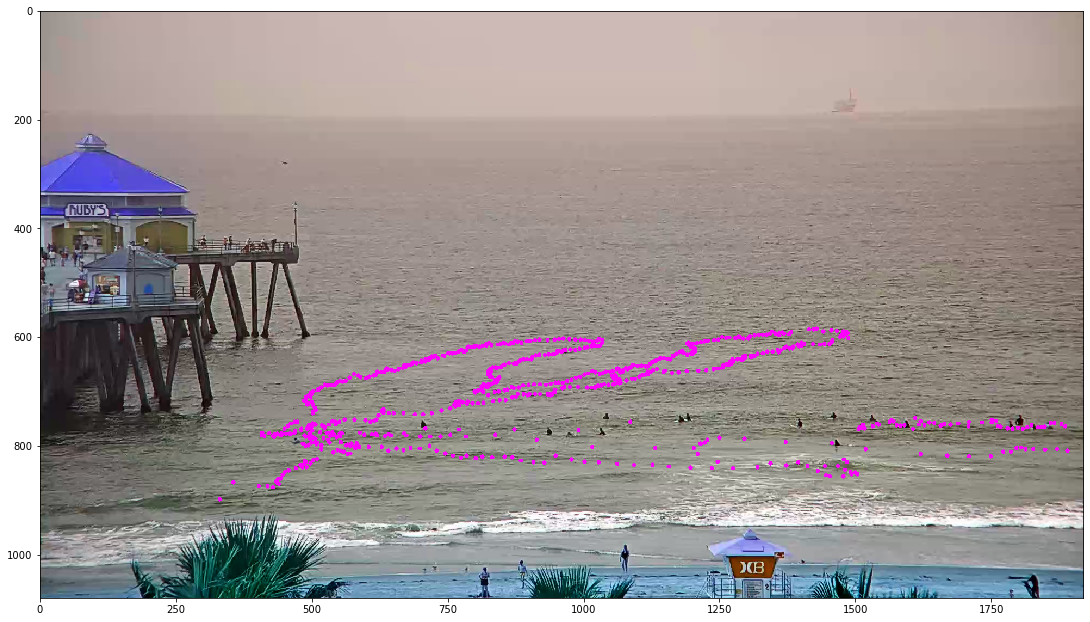

In [14]:
vidcap = cv2.VideoCapture('./data/hb_n_v2.mp4')
success,image = vidcap.read()

source_points = []
dest_points = []

for index, row in dat.iterrows():
    dest_points.append([int(row['x']), int(row['y'])])
    source_points.append([round(float(row['Y']),6), round(float(row['X']),6)])
    cv2.circle(image, (int(row['x']), int(row['y'])), 4, (255, 0, 255), -1)

plt.figure(figsize=(19.2, 10.8))
plt.imshow(image)

source_points = np.array(source_points)
dest_points = np.array(dest_points)

In [15]:
#dest_points = np.vstack([dest_points, [[1109, 449]]])
#source_points = np.vstack([source_points, [[33.5956, -118.1300364]]])

hom = cv2.findHomography(source_points[20:], dest_points[20:], method=cv2.RANSAC)[0]
print(hom)

[[-3.03188640e+02  3.51858658e+02  5.17246826e+04]
 [ 2.33656383e+01 -4.63272763e-01 -8.41199847e+02]
 [ 6.00905689e-02  2.56136838e-02  1.00000000e+00]]


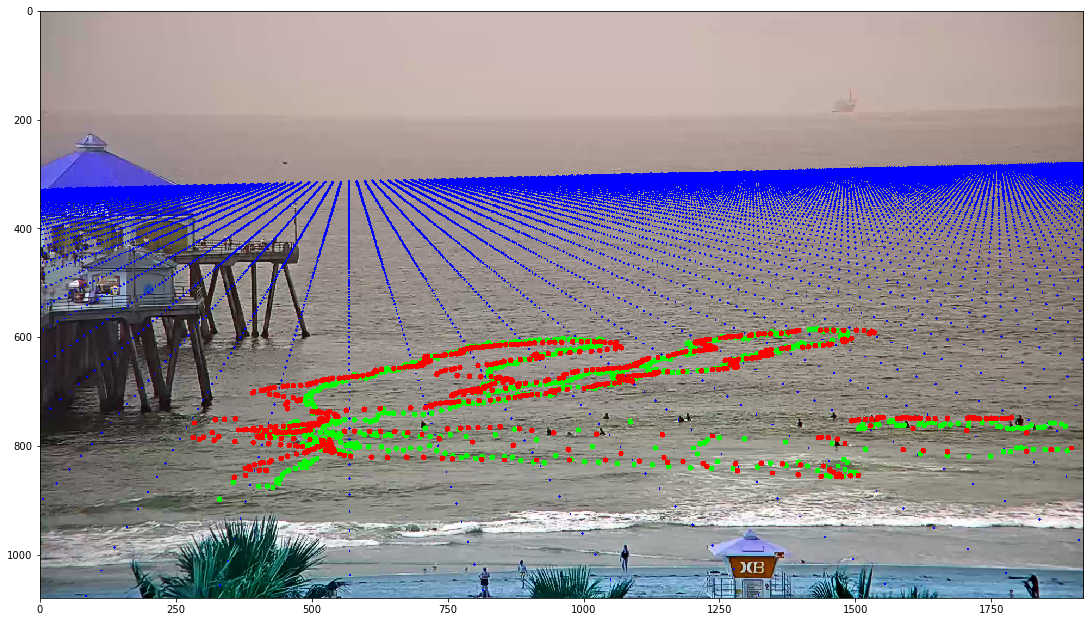

In [16]:
def get_xy(lat, lon, hom):
    inp = [lat, lon, 1]
    res = np.matmul(hom, inp)
    x = res[0] / res[2]
    y = res[1] / res[2]
    return int(x), int(y)

def visualize(source_points, dest_points, hom):

    vidcap = cv2.VideoCapture('./data/hb_n_v2.mp4')
    success,image = vidcap.read()
    
    # Show the grid in blue
    for lat in np.arange(33.63, 33.80, 0.0001):
        for lon in np.arange(-118.003, -118.04, -0.0001):
            sp = get_xy(lat, lon, hom)
            if 0 < sp[0] < 2000:
                if 0 < sp[1] < 2000:
                    cv2.circle(image, (sp[0], sp[1]), 2, (0, 0, 255), -1)

    # Show the tower, pylon and hut source points in green
    for point in source_points:
        cv2.circle(image, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1)

    # Show the estimated pylon, hut and pier points in red
    for point in dest_points:
        sp = get_xy(point[0], point[1], hom)
        cv2.circle(image, (sp[0], sp[1]), 5, (255, 0, 0), -1)
         
    plt.figure(figsize=(19.2, 10.8))
    plt.imshow(image)
    
visualize(dest_points, source_points, hom)

In [17]:
import homography

In [21]:
my_hom = homography.get_RANSAC_homography(source_points, dest_points, iter=100000)
print(my_hom)

(array([[-5.97251010e+01,  6.13060731e+01,  9.24442835e+03],
       [-2.08624544e+00,  2.48309236e+00,  3.63199217e+02],
       [ 1.10514264e-03,  8.78972002e-03,  1.00000000e+00]]), [15, 550, 352, 383])


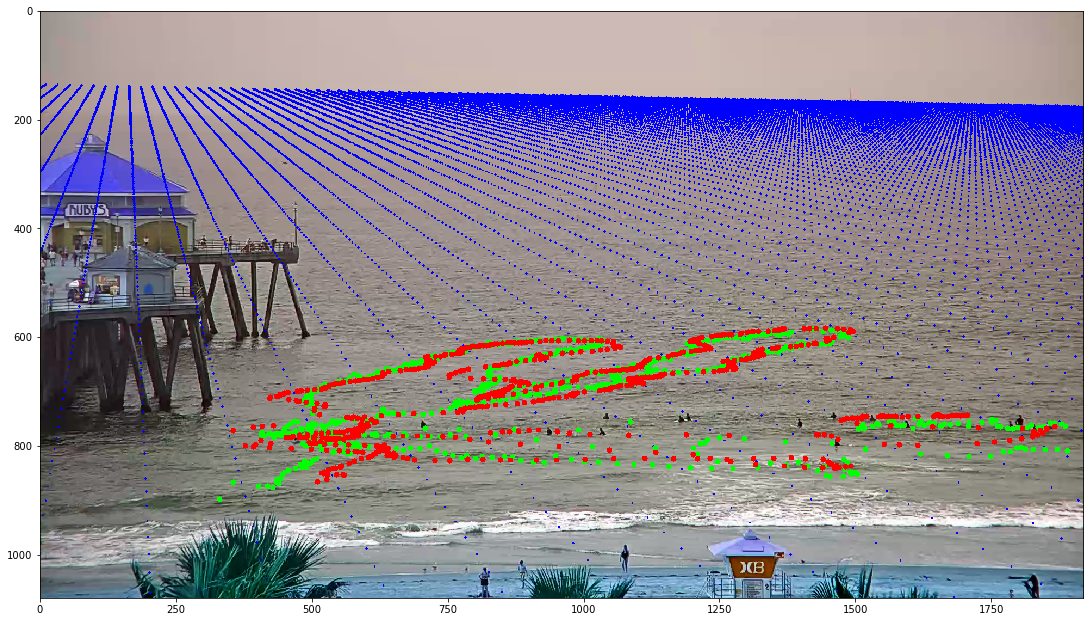

In [22]:
visualize(dest_points, source_points, my_hom[0])